# Clustering

Clustering ist ein *Task* im Bereich unüberwachtes Lernen (unsupervised learning). Hier werden wir uns mit Clustering von *Zeitreihen* beschäftigen.

<div class="alert alert-block alert-success">

Clustering von *Zeitreihen* kann sehr rechenintensiv werden. Im folgenden werden wir versuchen, den Stromverbrauch von Haushalten zu clustern.
</div>


Import von Standard Bibliotheken:

In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans,silhouette_score
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import urllib.request
import zipfile
from pytictoc import TicToc

<div class="alert alert-info">

In diesem Notebook arbeiten wir mit dem *UCI Individual household electric power consumption* Datensatz (https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption). 

Dieses Archiv enthält Messungen, die in Häusern in Sceaux (7km außerhalb von Paris, Frankreich) zwischen
Dezember 2006 and November 2010 aufgezeichnet wurden, also 47 Monate. Der Datensatz hat einen Zeitstempel pro Minute, das heißt **1 Tag enthält 24*60=1440 Messwerte**.
    
Die Idee ist, mit einem Clustering-Algorithmus ähnliche Tage zu bestimmen.
    
Der Code ist teilweise übernommen von https://tslearn.readthedocs.io/en/stable/auto_examples/clustering/plot_kmeans.html.  
    
    
</div>


Automatischer Download des Datensatzes (wird im aktuellen Verzechnis gespeichert):

In [3]:
# download ca. 20MB
url = "https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip"
urllib.request.urlretrieve(url, "household_power_consumption.zip")

('household_power_consumption.zip', <http.client.HTTPMessage at 0x2970ecbf1f0>)

Falls Sie das zip-File manuell runtergeladen haben, können Sie optional hier den Dateipfad nochmal anpassen. Beispiel:

r'C:\Users\schroth\PycharmProjects\Maschinelles_Lernen_Zeitreihen'

In [5]:
start_path = Path(
    r'.'
)

Unzip des Datensatzes:

In [6]:
with zipfile.ZipFile("./household_power_consumption.zip", 'r') as zip_ref:
    zip_ref.extractall(path=".")

# I. Daten Aufbereiten (Preprocessing)

In [7]:
df_orig = pd.read_csv(
    start_path / 'household_power_consumption.txt', sep=';',decimal='.',na_values='?'
)
print('Fehlene Werte (Anteil):')
print(df_orig.isna().sum().sum()/(df_orig.shape[0]*df_orig.shape[1]))

Fehlene Werte (Anteil):
0.009736562467089115


Es fehlen etwa 1% an Daten.

Man könnte sich überlegen, Einträge mit fehlenden Werten einfach rauszuschmeißen, allerdings muss man für die Analyse den ganzen Tag entfernen, wenn nur 1 Messwert fehlt. 

Behandeln von fehlenden Werten (missing values) durch Auffüllen mit 0en:

In [8]:
df = df_orig.copy()
df = df.fillna(0)

In [9]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


Wir müssen zunächst die Zeitstempel richtig setzen:

In [10]:
timestamps = df.Date.str.cat(df.Time,sep='-')
# setze das Datum (rechte Spalte) als Index (dies kann ein paar Sekunden dauern)
df = df.set_index( pd.to_datetime(timestamps, format='%d/%m/%Y-%H:%M:%S') )
# redudante Spalten löschen
df.pop('Date')
df.pop('Time')
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


Der erste Tag (siehe oben) und der letzte Tag (siehe unten) sind nicht ganz vollständig, hier noch die letzten Werte:

In [11]:
df.tail()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date,,,,,,,
2010-11-26 20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.0,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2010-11-26 21:01:00,0.934,0.0,239.70,3.8,0.0,0.0,0.0
2010-11-26 21:02:00,0.932,0.0,239.55,3.8,0.0,0.0,0.0


Wir löschen jeweils den ersten und letzten Tag und berechnen, wie viele Tage wir bekommen:

In [12]:
df=df[df.index>'2006/12/17']
df=df[df.index<='2010/11/25']
print(len(df)/(24*60)) # should be 1439.0

1439.0


Unter https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption kann man die Bedeutung der  Spalten *['Sub_metering_1', 'Sub_metering_2','Sub_metering_3']* nachlesen: 

- sub_metering_1 (in Wattstunden): entspricht der Küche, die hauptsächlich einen Geschirrspüler, einen Backofen und eine Mikrowelle enthält (die Kochplatten sind nicht elektrisch, sondern gasbetrieben),
- sub_metering_2 (in Wattstunden): entspricht der Waschküche, die eine Waschmaschine, einen Wäschetrockner, einen Kühlschrank und eine Lampe enthält,
- sub_metering_3 (in Wattstunden): entspricht einem elektrischen Warmwasserbereiter und einem Klimagerät.

Beispielplot der Messungen für 5 Tage, man erkennt deutliche Unterschiede zwischen den Tagen:

<IPython.core.display.Javascript object>


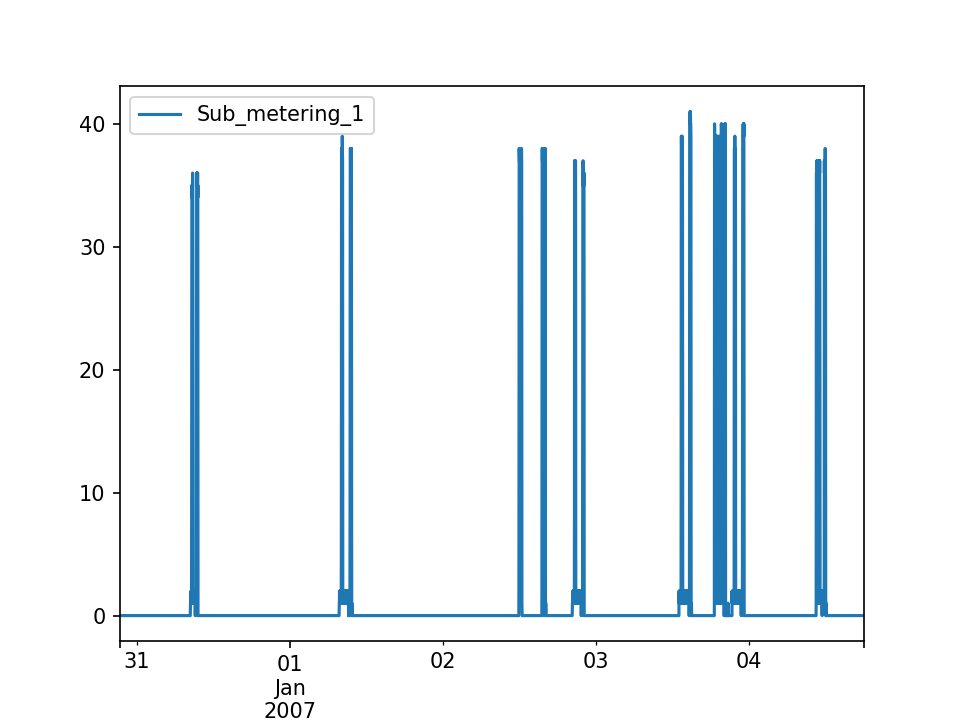

In [17]:
df.iloc[20000:27000][['Sub_metering_1']].plot();

# II. k-means Clustering

k-means ist eine der bekanntesten Methoden für Clustering. Wir verwenden ausschließlich die Werte von Sub_metering_1 (Stromverbrauch Küche mit Gasherd).

Auslesen der Daten in X_train, umsortieren als Vektoren:

In [18]:
X_train = df.Sub_metering_1.values
X_train = X_train.reshape(1440,int(len(X_train)/1440), order='F').T #  24*60 = 1440 (Zeitstempel pro Tag)
np.random.seed(42)
np.random.shuffle(X_train)

<div class="alert alert-block alert-success">

Bei Clustering hat man im Vergleich zu Classification ***KEINE LABELS***. Deshalb kann man das Modell nicht an einem Test-Datenset testen. Die Evaluation läuft über den Silouetten-Koeffizient (https://de.wikipedia.org/wiki/Silhouettenkoeffizient).
</div>


In [19]:
# Parameter, die durch den Benutzer angepasst werden können
n_time_series = 1439  # Anzahl der Zeitreihen, maximal 1439 von oben
n_max = 10  # maximale Anzahl an Cluster

Die Berechnung der Cluster von 1 bis n_max:

In [20]:
silhouette_result={}
for n in range(2,n_max):
    print(f'n: {n}')
    X_train2 = TimeSeriesScalerMeanVariance().fit_transform(X_train[:n_time_series])
    km = TimeSeriesKMeans(n_clusters=n, verbose=True, random_state=42)
    y_pred = km.fit_predict(X_train2)
    silhouette_result[str(n)] = silhouette_score(X_train2, y_pred, metric="euclidean")

n: 2
1114.276 --> 1084.715 --> 1070.003 --> 1060.063 --> 1058.497 --> 1058.192 --> 1057.947 --> 1057.691 --> 1057.598 --> 1057.567 --> 1057.406 --> 1057.221 --> 1057.129 --> 1057.101 --> 1057.077 --> 1057.065 --> 1057.065 --> 
n: 3
1100.291 --> 1059.449 --> 1048.739 --> 1041.282 --> 1037.293 --> 1035.334 --> 1034.026 --> 1033.070 --> 1032.681 --> 1032.220 --> 1031.868 --> 1031.518 --> 1031.224 --> 1030.943 --> 1030.764 --> 1030.472 --> 1030.148 --> 1029.967 --> 1029.883 --> 1029.811 --> 1029.719 --> 1029.658 --> 1029.528 --> 1029.397 --> 1029.281 --> 1029.161 --> 1029.060 --> 1029.029 --> 1029.011 --> 1028.997 --> 1028.993 --> 1028.986 --> 1028.981 --> 1028.977 --> 1028.977 --> 
n: 4
1093.680 --> 1047.857 --> 1032.349 --> 1021.069 --> 1015.569 --> 1011.350 --> 1008.021 --> 1005.941 --> 1004.978 --> 1004.482 --> 1004.028 --> 1003.647 --> 1003.367 --> 1003.164 --> 1002.883 --> 1002.724 --> 1002.671 --> 1002.563 --> 1002.421 --> 1002.285 --> 1002.122 --> 1001.972 --> 1001.918 --> 1001.877

Ausgabe der Silhouettenwerte, es gilt folgende Einteilung für die Strukturierung (https://de.wikipedia.org/wiki/Silhouettenkoeffizient):
    
- stark: 0.75 < S ≤ 1 
- mittel: 0.5 < S ≤ 0.75
- schwach: 0.25 < S ≤ 0.5
- keine Struktur: 0 < S ≤ 0.25

In [21]:
for s in silhouette_result:
    print(f'n:{s}, Wert: {silhouette_result[s]}')

n:2, Wert: 0.11345693453855438
n:3, Wert: 0.11713373851940148
n:4, Wert: 0.12229698985231653
n:5, Wert: 0.11702193395863368
n:6, Wert: 0.12238286044397463
n:7, Wert: 0.12469792375961218
n:8, Wert: 0.12393739298761482
n:9, Wert: 0.12714453630826364


<div class="alert alert-block alert-success">

Hier ist kein Zusammenhang zu erkennen, die Cluster sind nicht gut gewählt.
</div>

Resultate plotten (der Einfachheit halber nur für n_max, also das letzte Cluster):

<IPython.core.display.Javascript object>


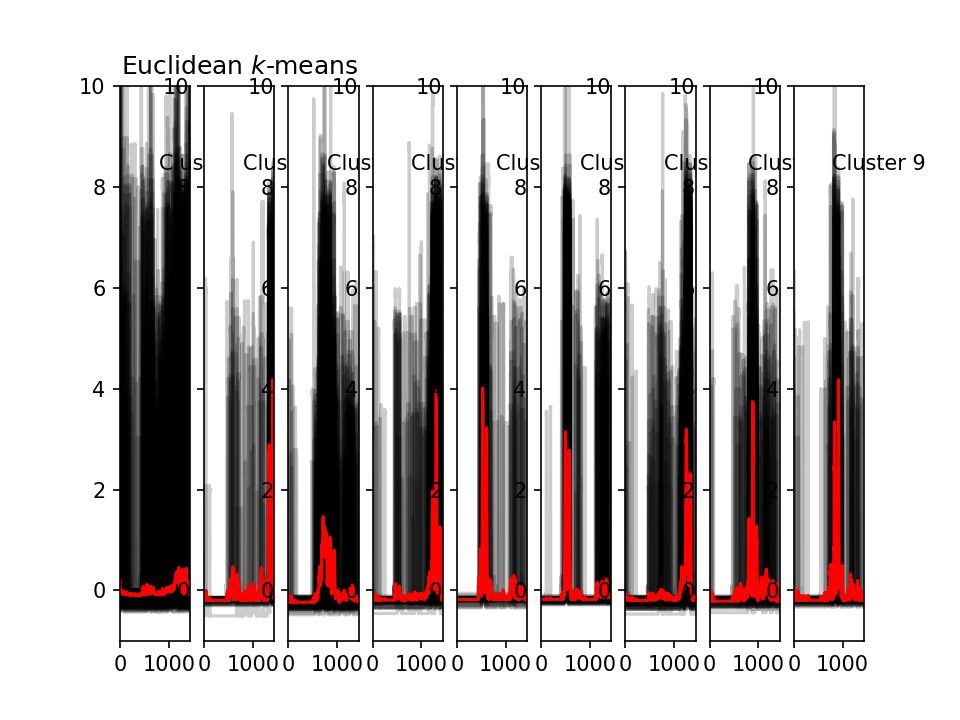

In [22]:
plt.figure()
for yi in range(n):
    plt.subplot(1, n, yi+1)
    for xx in X_train2[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, X_train2.shape[1])
    plt.ylim(-1, 10)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

Weitere Infos über das Cluster (der Einfachheit halber nur für n_max):

In [23]:
for yi in range(n):
    print('Anzahl Instanzen Instanzen in Cluster ', yi,':')
    print((km.labels_==yi).sum())

Anzahl Instanzen Instanzen in Cluster  0 :
665
Anzahl Instanzen Instanzen in Cluster  1 :
45
Anzahl Instanzen Instanzen in Cluster  2 :
145
Anzahl Instanzen Instanzen in Cluster  3 :
120
Anzahl Instanzen Instanzen in Cluster  4 :
60
Anzahl Instanzen Instanzen in Cluster  5 :
123
Anzahl Instanzen Instanzen in Cluster  6 :
149
Anzahl Instanzen Instanzen in Cluster  7 :
68
Anzahl Instanzen Instanzen in Cluster  8 :
64


# III. DTW k-means Clustering

<div class="alert alert-info">

Dynamic Time Warping ist eine weitere Möglichkeit, Abstände zwischen Zeitreihen zu berechnen.
    
Die Methode ist liefert oft bessere Ergebnisse, benötigt aber **deutlich mehr Rechenzeit**.
    
Ein Youtube Tutorial zu DTW: https://youtu.be/ERKDHZyZDwA (Dynamic time warping Herman Kamper).
    
    
</div>


Wir starten mit 4 Clustern (wir werden weiter unten noch sehen, dass man mit 4 Clustern das beste Resultat bekommt) und beobachten die Rechenzeit:

In [24]:
# Parameter, die der Benutzer anpassen kann
n_time_series = 700  # Wegen der langen Rechenzeit verwenden wir nur etwa die Hälfte der Zeitreihen.
n = 4 # Anzahl der Cluster

<div class="alert alert-danger">
    
**Hinweis:**

Ein Rechenvorgang kann mehrere Minuten in Anspruch nehmen.

</div>


In [25]:
t = TicToc()  # Instanz für die Laufzeitmessung
X_train2 = TimeSeriesScalerMeanVariance().fit_transform(X_train[:n_time_series])
t.tic()
km_dtw = TimeSeriesKMeans(n_clusters=n,
                          metric="dtw",
                          max_iter=10,
                          verbose=True,
                          random_state=42)
y_pred_dtw = km_dtw.fit_predict(X_train2)
t.toc()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 700 out of 700 | elapsed:   10.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2100 out of 2100 | elapsed:   30.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2100 out of 2100 | elapsed:   33.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2100 out of 2100 | elapsed:   35.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2800 out of 2800 | elapsed:   43.4s finished


132.660 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2800 out of 2800 | elapsed:   40.4s finished


98.982 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2800 out of 2800 | elapsed:   39.4s finished


98.456 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2800 out of 2800 | elapsed:   39.4s finished


98.229 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2800 out of 2800 | elapsed:   39.8s finished


97.369 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2800 out of 2800 | elapsed:   43.8s finished


94.690 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2800 out of 2800 | elapsed:   40.2s finished


94.125 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2800 out of 2800 | elapsed:   39.8s finished


94.003 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2800 out of 2800 | elapsed:   39.9s finished


93.999 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2800 out of 2800 | elapsed:   41.8s finished


93.999 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Elapsed time is 2276.398586 seconds.


[Parallel(n_jobs=1)]: Done 2800 out of 2800 | elapsed:   40.5s finished


<div class="alert alert-danger">
    
**Hinweis:**

Folgender Rechenvorgang wird noch wesentlich länger dauern als der obige.

</div>


In [26]:
t.tic()
print(silhouette_score(X_train2, y_pred_dtw, metric="dtw"))
t.toc()

0.5101291609430807
Elapsed time is 3706.722118 seconds.


Wir haben damit einen Silhouettenwert von ca. 51%, ist nicht ganz oprimal aber deutlich besser als oben.

Plot für die Cluster:

<IPython.core.display.Javascript object>


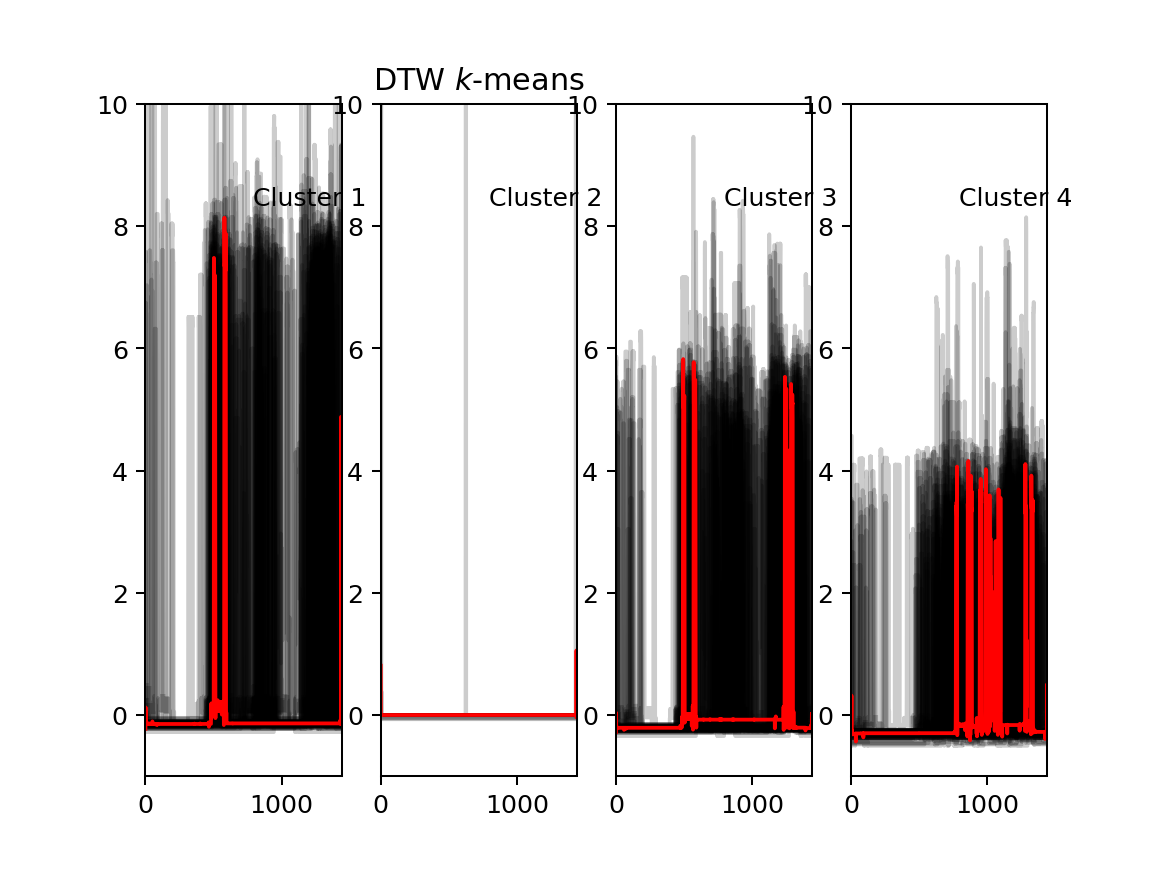

In [27]:
plt.figure()
for yi in range(n):
    plt.subplot(1, n, yi+1)
    for xx in X_train2[y_pred_dtw == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km_dtw.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, X_train.shape[1])
    plt.ylim(-1, 10)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means")

Eine Ausgabe über die Anzahl der Elemente in jedem Cluster:

In [28]:
for yi in range(n):
    print('number of instances in cluster ', yi,':')
    print((km_dtw.labels_==yi).sum())

number of instances in cluster  0 :
287
number of instances in cluster  1 :
148
number of instances in cluster  2 :
154
number of instances in cluster  3 :
111


### Verkürzen der Zeitreihen

<div class="alert alert-block alert-success">

DTW ist wie wir oben gesehen haben relativ rechenintensiv. Dies kann man abkürzen, indem man die Zeitreihen zusammenfasst. Zum Beispiel koennte man die Daten so zusammenfassen, dass man nicht 1x pro Minute, sondern nur 1x pro 10 Minuten einen Zeitstempel hat. Die tslearn Bibliothek benutzt dafuer den Befehl TimeSeriesResampler().
</div>

Mit folgendem Code werden die Zeitreihen verkürzt und die Berechnungen werden schneller. Allerdings muss man in Kauf nehmen, dass Werte zusammengefasst werden, ein Teil der ursprünglichen Information geht bei der Berechnung verloren.

In [29]:
from tslearn.preprocessing import TimeSeriesResampler

In [30]:
# Parameter, die durch den Benutzer angepasst werden können
n_time_series = 1439  # maximal 1439 von oben, dieses Mal alle Zeitreihen
n_max = 10  # maximale Anzahl an Cluster
my_size = 144  # Größe der ausgegebenen Zeitreihe; 144=1440/10, heißt wir verkürzen um den Faktor 10 

In [31]:
X_train2 = TimeSeriesResampler(sz=my_size).fit_transform(X_train[:n_time_series])
print(X_train2.shape)

(1439, 144, 1)


In [32]:
silhouette_result2={}
for n in range(2,n_max+1):
    print(n)
    t.tic()
    km_dtw = TimeSeriesKMeans(n_clusters=n,
                          metric="dtw",
                          max_iter=10,
                          verbose=False,
                          random_state=42)
    y_pred_dtw = km_dtw.fit_predict(X_train2)
    silhouette_result2[str(n)] = silhouette_score(X_train2, y_pred_dtw, metric="dtw")
    t.toc()

2
Elapsed time is 1294.747018 seconds.
3
Elapsed time is 1269.692012 seconds.
4
Elapsed time is 1314.707728 seconds.
5
Elapsed time is 1395.533253 seconds.
6
Elapsed time is 1271.841336 seconds.
7
Elapsed time is 1264.804330 seconds.
8
Elapsed time is 1267.804141 seconds.
9
Elapsed time is 1260.290537 seconds.


In [33]:
for s in silhouette_result2:
    print(f'n:{s}, Wert: {silhouette_result2[s]}')

n:2, Wert: 0.4574836774224614
n:3, Wert: 0.4991803850480901
n:4, Wert: 0.534346326120156
n:5, Wert: 0.5143594685542688
n:6, Wert: 0.5208381626674372
n:7, Wert: 0.5161327823173409
n:8, Wert: 0.5523326468430432
n:9, Wert: 0.5507760109878066


## Fazit

<div class="alert alert-block alert-success">

Tatsächlich scheint ein Clustering mit n=4 Clustern am meisten Sinn zu machen. Es ist aber bei weitem noch kein "gutes" Cluster. **Im Prinzip haben wir nur die Metric von 'Euclidean' auf 'dtw' gesetzt, und damit wesentlich bessere Cluster erhalten.** Oft muss man wissen, an welcher Stelle man was abändern muss, damit die Ergebnisse besser werden.
    
Wenn man den TimeSeriesResampler weglässt und noch weitere Messreihen (sprich: weitere Strommessungen über mehrere Jahre) reinnehmen würde, würde man sicherlich noch bessere Cluster bekommen.
</div>